# LAB 5.1 Multiscale Unsharp Masking

In [1]:
import cv2
import numpy as np,sys
import matplotlib.pyplot as plt 
from skimage.io import imread

(<AxesSubplot:title={'center':'Stacked Image'}>,
 Text(0.5, 1.0, 'Stacked Image'))

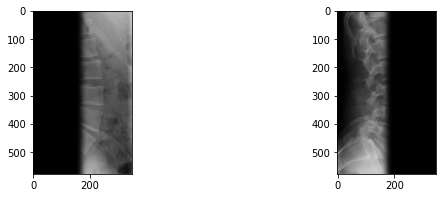

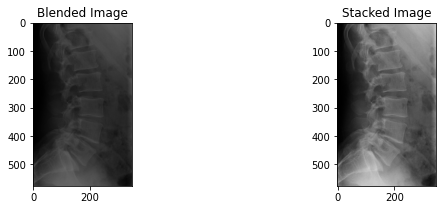

In [2]:

image0 = cv2.imread("/Users/kunanonjarat/Downloads/spine2.jpg")
image1 = cv2.imread("/Users/kunanonjarat/Downloads/spine2.jpg")
#image1 = cv2.resize(image1, image0.shape[1::-1])

n = image0.shape
mask0 = np.ones(n)
ncols = n[1]//2

# stack up the image 
ims = np.hstack((image0[:,0:ncols], image1[:,ncols:]))


mask0[:,:ncols] = 0
mask0 = cv2.GaussianBlur(mask0,(51,51),10)
#mask0 = np.uint8(255*mask0) 
mask0 = mask0
mask1 = 1-mask0

#image0 = cv2.bitwise_and(image0, mask0)
#image1 = cv2.bitwise_and(image1, mask1)

image0 = np.uint8(image0*mask0)
image1 = np.uint8(image1*mask1)

alpha = 0.5
blended = alpha * image0 + (1 - alpha) * image1 
blended = np.uint8(blended)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)) 
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)), plt.title('Blended Image')
plt.subplot(1,2,2), plt.imshow(cv2.cvtColor(ims, cv2.COLOR_BGR2RGB)), plt.title('Stacked Image')

In [3]:
A = cv2.imread("/Users/kunanonjarat/Downloads/spine2.jpg")
B = cv2.imread("/Users/kunanonjarat/Downloads/spine2.jpg")

# generate Gaussian pyramid for A
layer = A.copy()
gaussian_pyramid_a = [layer]
for i in range(6):
    layer = cv2.pyrDown(layer)
    gaussian_pyramid_a.append(layer)

# generate Gaussian pyramid for B
layer =B.copy()
gaussian_pyramid_b = [layer]
for i in range(6):
    layer = cv2.pyrDown(layer)
    gaussian_pyramid_b.append(layer)

    
# Laplacian Pyramid
layer_a = gaussian_pyramid_a[5]
#cv2.imshow("6", layer)
laplacian_pyramid_a = [layer_a]
for i in range(5, 0, -1):
    size = (gaussian_pyramid_a[i-1].shape[1], gaussian_pyramid_a[i-1].shape[0])
    gaussian_expanded_a = cv2.pyrUp(gaussian_pyramid_a[i], dstsize=size)
    laplacian_a = cv2.subtract(gaussian_pyramid_a[i-1], gaussian_expanded_a)
    laplacian_pyramid_a.append(laplacian_a)
# Laplacian Pyramid
layer = gaussian_pyramid_b[5]
#cv2.imshow("6", layer)
laplacian_pyramid_b = [layer]
for i in range(5, 0, -1):
    size = (gaussian_pyramid_b[i-1].shape[1], gaussian_pyramid_b[i-1].shape[0])
    gaussian_expanded_b = cv2.pyrUp(gaussian_pyramid_b[i], dstsize=size)
    laplacian_b = cv2.subtract(gaussian_pyramid_b[i-1], gaussian_expanded_b)
    laplacian_pyramid_b.append(laplacian_b)
    

(<matplotlib.image.AxesImage at 0x1777aef70>,
 Text(0.5, 1.0, 'Pyramid_blending'))

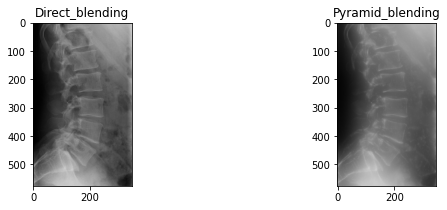

In [4]:
#from keras.preprocessing.image import array_to_img

# Now add left and right halves of images in each level
LS = []
for la,lb in zip(laplacian_pyramid_a,laplacian_pyramid_b):
    rows,cols,dept = la.shape
    ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
    LS.append(ls)
    
# now reconstruct
ls_ = LS[0]
for i in range(1,6):
    size = (LS[i].shape[1],LS[i].shape[0])
    ls_ = cv2.pyrUp(ls_, dstsize=size)
    ls_ = cv2.add(ls_, LS[i])
    
# image with direct connecting each half
real = np.hstack((A[:,:cols//2],B[:,cols//2:]))

#cv2.imwrite('Pyramid_blending2.jpg',ls_)
#cv2.imwrite('Direct_blending.jpg',real)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1), 
plt.imshow(cv2.cvtColor(real, cv2.COLOR_BGR2RGB)), plt.title('Direct_blending')
plt.subplot(1,2,2), 
plt.imshow(cv2.cvtColor(ls_, cv2.COLOR_BGR2RGB)), plt.title('Pyramid_blending')

# LAB 5.2 Pyramid based Image Blending

In [36]:
import cv2
import numpy as np
 
 
# Step-2
# Find the Gaussian pyramid of the two images and the mask
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyr.append(np.float32(lower))
    return gaussian_pyr
 
# Step-3
# Then calculate the Laplacian pyramid
def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr
 
# Step-4
# Now blend the two images wrt. the mask
def blend(laplacian_A,laplacian_B,mask_pyr):
    LS = []
    for la,lb,mask in zip(laplacian_A,laplacian_B,mask_pyr):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)
    return LS
 
# Step-5
# Reconstruct the original image
def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1
    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyr[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst
 
# Now let's call all these functions
if __name__ == '__main__':
    # Step-1
    # Load the two images
    img1 = cv2.imread('/Users/kunanonjarat/Downloads/cloud1.jpg')
    img1 = cv2.resize(img1, (1800, 1000))
    img2 = cv2.imread('/Users/kunanonjarat/Downloads/jet.jpg')
    img2 = cv2.resize(img2, (1800, 1000))
 
    # Create the mask
    mask = np.zeros((1000,1800,3), dtype='float32')
    mask[250:500,640:1440,:] = (1,1,1)
    
    num_levels = 7
    
    # For image-1, calculate Gaussian and Laplacian
    gaussian_pyr_1 = gaussian_pyramid(img1, num_levels)
    laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)
    # For image-2, calculate Gaussian and Laplacian
    gaussian_pyr_2 = gaussian_pyramid(img2, num_levels)
    laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)
    # Calculate the Gaussian pyramid for the mask image and reverse it.
    mask_pyr_final = gaussian_pyramid(mask, num_levels)
    mask_pyr_final.reverse()
    # Blend the images
    add_laplace = blend(laplacian_pyr_1,laplacian_pyr_2,mask_pyr_final)
    # Reconstruct the images
    final  = reconstruct(add_laplace)
    # Save the final image to the disk
    cv2.imwrite('/Users/kunanonjarat/Downloads/tothemoon.jpg',final[num_levels])